In [6]:
import umap
import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


In [7]:
from sklearn.manifold import TSNE
import umap

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [8]:
mnist_full = sklearn.datasets.fetch_openml('mnist_784')
fmnist_full = sklearn.datasets.fetch_openml('Fashion-MNIST')

In [9]:
# mnist.data.shape
import types

LIMIT = mnist_full.data.shape[0]

mnist_limited = types.SimpleNamespace()
mnist_limited.data = mnist_full.data[:LIMIT]
mnist_limited.target = mnist_full.target[:LIMIT]

fmnist_limited = types.SimpleNamespace()
fmnist_limited.data = fmnist_full.data[:LIMIT]
fmnist_limited.target = fmnist_full.target[:LIMIT]

In [10]:
mnist = mnist_limited
fmnist = fmnist_limited

Below are drawings of some samples from mnist and fmnist data sets

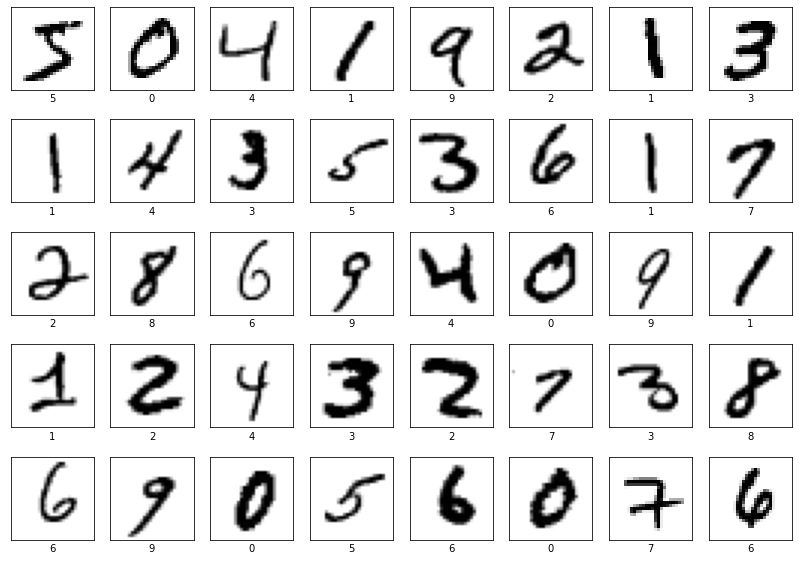

In [11]:
mnist_names = [i for i in range(10)]

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data.iloc[i].to_numpy().reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

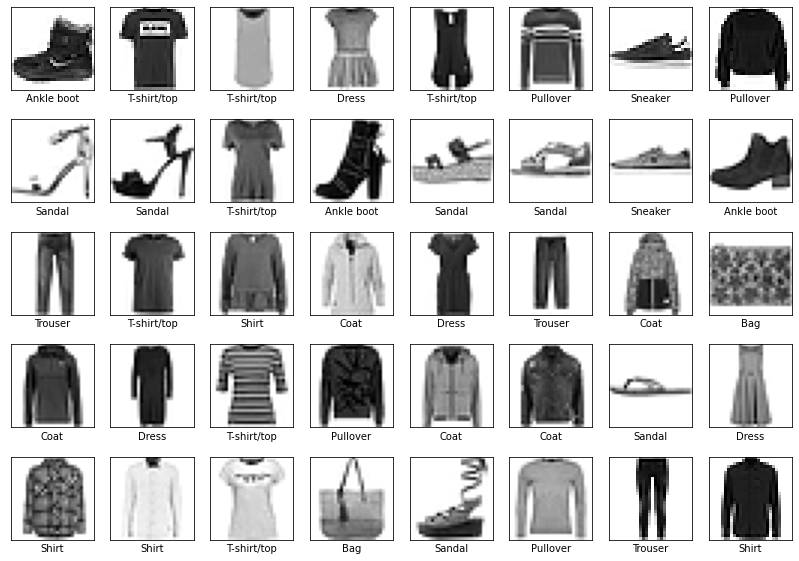

In [12]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data.iloc[i].to_numpy().reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

In [13]:
from sklearn.manifold import TSNE

def run_tsne(points):
    points_transformed = TSNE(n_components=2,
                              metric='euclidean',
                              perplexity=30.,
                              n_iter=1000,
                              init='pca',
                              learning_rate='auto').fit_transform(points)
    return points_transformed

In [46]:
plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 20

def visualize_points(points, target, title):
    fig, ax = plt.subplots()

    target_labels = target.to_numpy().astype(np.int8)
    for group in np.unique(target_labels):
        idx = np.where(target_labels == group)[0]
        ax.scatter(points[idx][:, 0], points[idx][:, 1], cmap=plt.cm.coolwarm, label=group, s=1)

    ax.set_title(title)
    ax.set_xlabel('X Component')
    ax.set_ylabel('Y Component')
    ax.legend(fontsize=10)

In [ ]:
mnist_tsne_X = run_tsne(mnist.data)

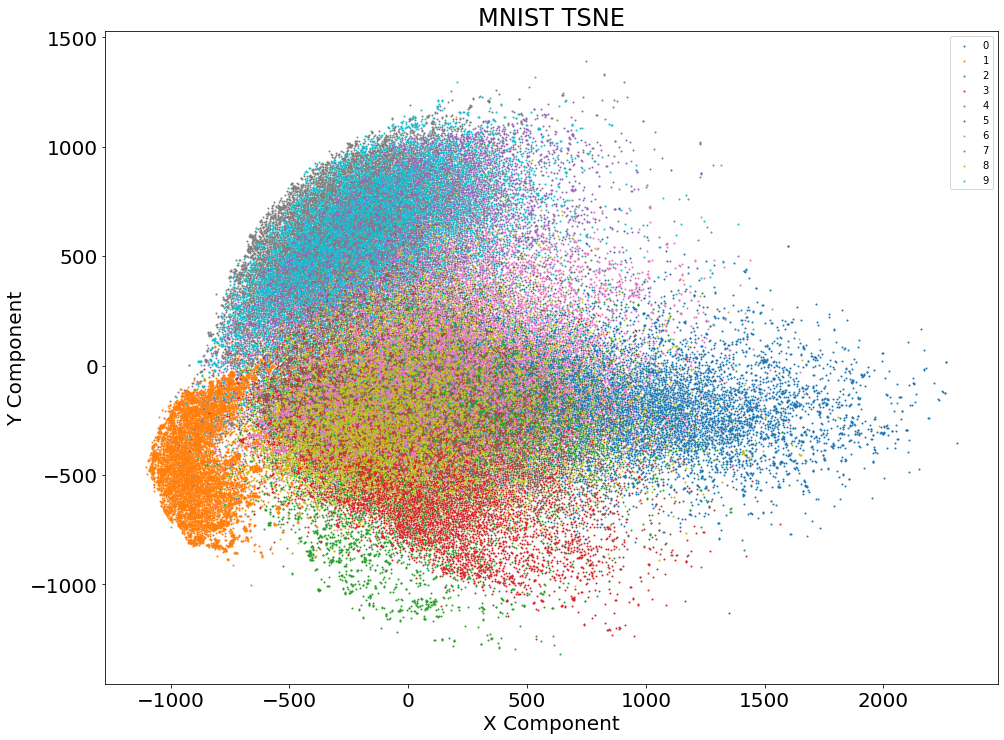

In [47]:
visualize_points(mnist_tsne_X, mnist.target, title="MNIST TSNE")

In [ ]:
fmnist_tsne_X = run_tsne(fmnist.data)

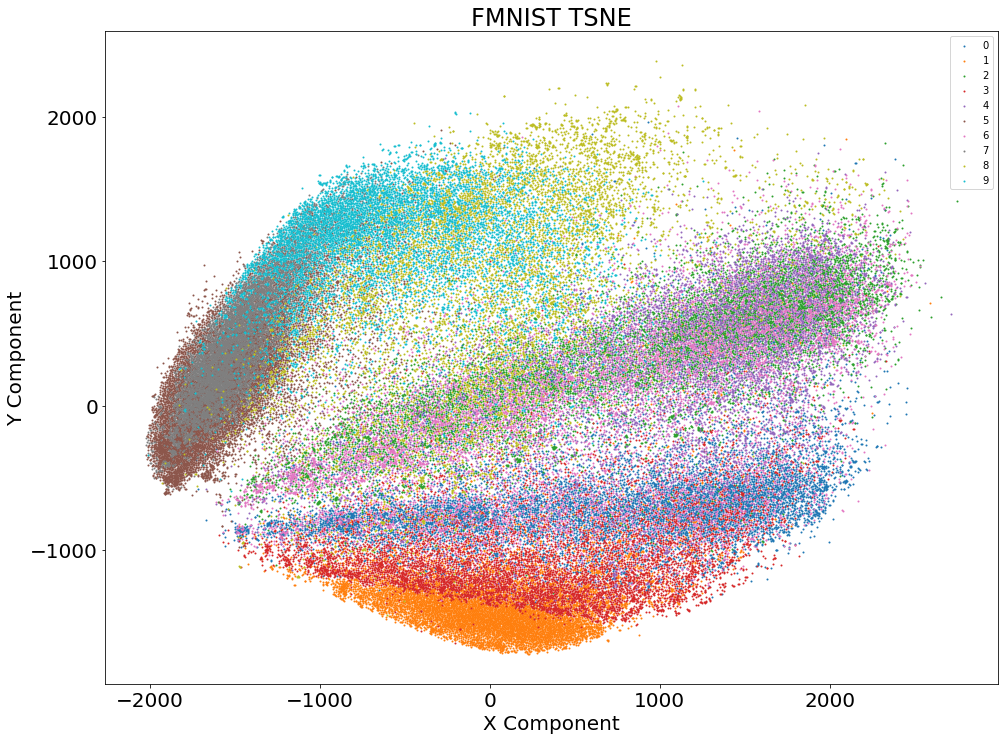

In [48]:
visualize_points(fmnist_tsne_X, fmnist.target, title='FMNIST TSNE')

In [17]:
umap_mapper_mnist = umap.UMAP().fit(mnist.data)
mnist_umap_X = umap_mapper_mnist.embedding_

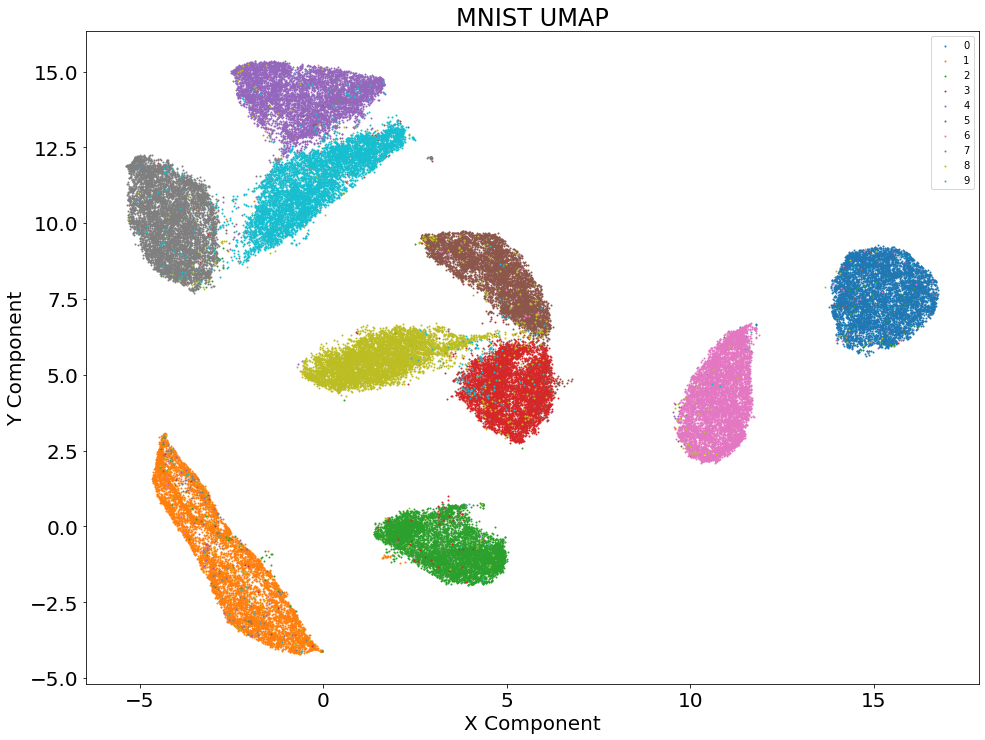

In [49]:
visualize_points(mnist_umap_X, mnist.target, title='MNIST UMAP')

In [19]:
# import umap.plot
# umap.plot.points(umap_mapper_mnist, labels=fmnist.target)

In [20]:
umap_mapper_fmnist = umap.UMAP().fit(fmnist.data)
fmnist_umap_X = umap_mapper_fmnist.embedding_

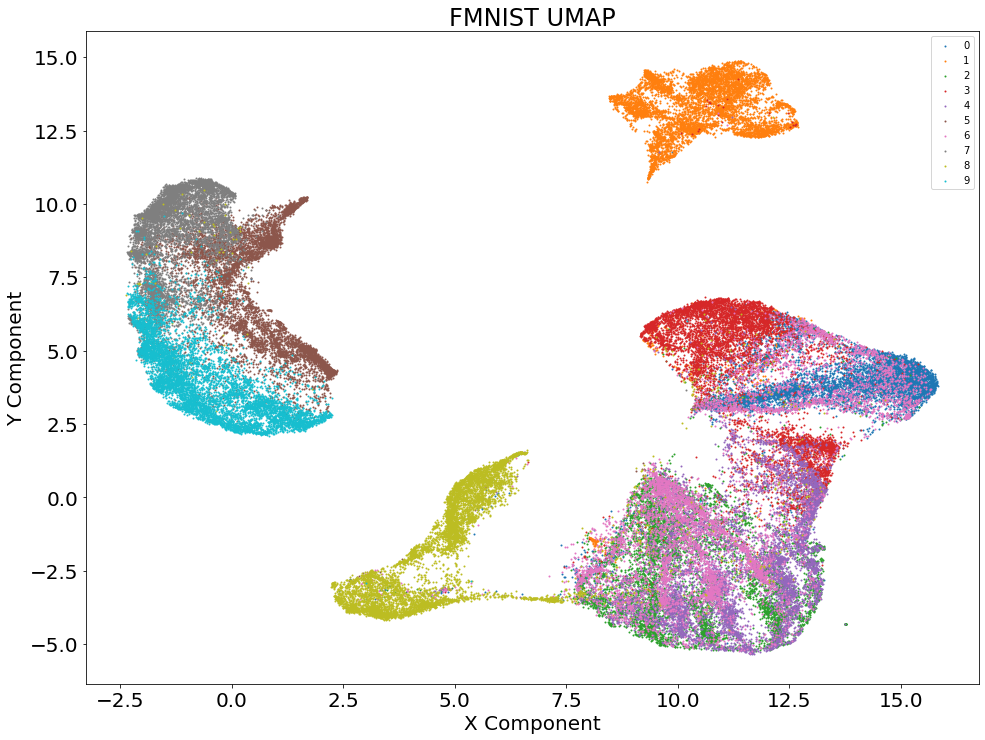

In [50]:
visualize_points(fmnist_umap_X, fmnist.target, title='FMNIST UMAP')

In [22]:
def save_largevis_input_data(data, filename):
    with open(filename, 'w') as f:
        shape = data.shape
        f.write(f'{shape[0]} {shape[1]}\n')
        for i in range(shape[0]):
            row = data.iloc[i].to_numpy()
            vals = []
            for v in row:
                vals.append(f'{v} ')
            f.write(''.join(vals) + '\n')

In [23]:
save_largevis_input_data(mnist.data, 'mnist_data.txt')
save_largevis_input_data(fmnist.data, 'fmnist_data.txt')

# At this point you should run largevis.
#! ./LargeVis/Linux/LargeVis -input ./lab3/fmnist_data.txt  -output ./lab3/fmnist_output.txt

In [24]:
def load_largevis_embedding(input_filename, limit=None):
    N = None
    with open(input_filename) as f:
        line = f.readline()
        vec = line.strip().split(' ')
        N = vec[0]

    embedding = []
    file_iterator = enumerate(open(input_filename))
    next(file_iterator)
    for i, line in file_iterator:
        vec = line.strip().split(' ')
        embedding.append(np.array([float(vec[0]), float(vec[1])]))
        if i == limit:
            break

    return np.array(embedding)

In [25]:
# largevis_mnist_data, largevis_mnist_label = load_data('./mnist_output.txt', mnist.target, LIMIT)
mnist_largevis_X = load_largevis_embedding('./mnist_output.txt', LIMIT)

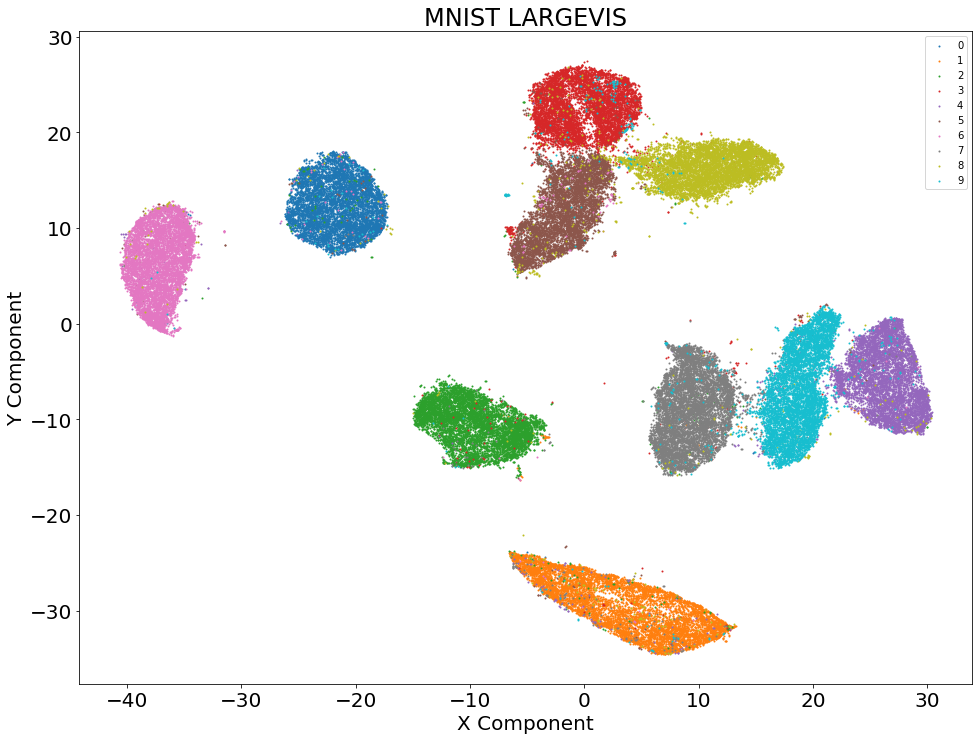

In [51]:
# show_largevis(largevis_mnist_data)
visualize_points(mnist_largevis_X, mnist.target, 'MNIST LARGEVIS')

In [27]:
fmnist_largevis_X = load_largevis_embedding('./fmnist_output.txt', LIMIT)

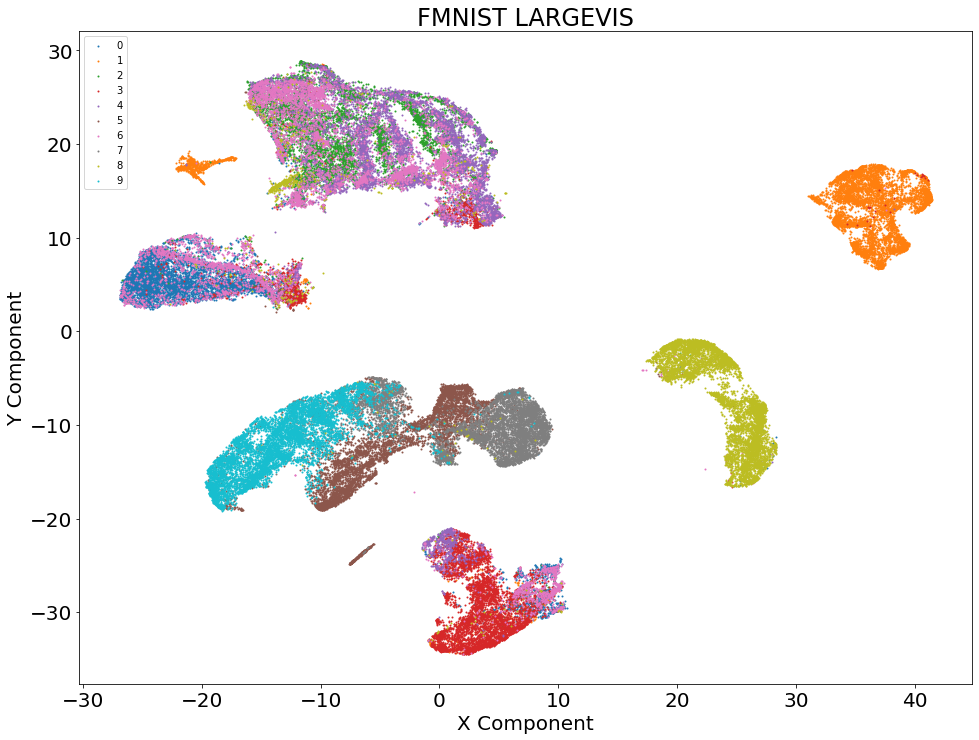

In [52]:
visualize_points(fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')

#### In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes

In [42]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def compute_inter_class_avg_dist(embedded_X, target):
    target_labels = target.to_numpy().astype(np.int8)
    centers = KMeans(n_clusters=np.unique(target_labels).shape[0]).fit(embedded_X).cluster_centers_
    n = centers.shape[0]

    n_distances = (((n * n) / 2) - n)
    return np.sum(cdist(centers, centers) / 2) / n_distances

In [43]:
def simple_avg_metric(embedded_X, target, method='group', group_size=500):
    target_labels = target.to_numpy().astype(np.int8)
    result_per_label = {}

    cross_class_dist = 0.0
    cross_class_count = 0
    for label in np.unique(target_labels):
        class_idx = np.where(target_labels == label)[:group_size]
        non_class_idx = np.where(target_labels != label)[:group_size]

        class_points = embedded_X[class_idx]

        n = class_points.shape[0]
        within_class_distances = np.sum(cdist(class_points, class_points)) / 2
        result_per_label[label] = within_class_distances / (((n * n) / 2) - n)

        if method == 'group':
            non_class_points = embedded_X[non_class_idx]
            cross_class_dist += np.sum(cdist(class_points, non_class_points))
            cross_class_count += class_points.shape[0] * non_class_points.shape[0]

    avg_cross_class_dist = 0.
    if method == 'knn':
        avg_cross_class_dist = compute_inter_class_avg_dist(embedded_X, target)
    elif method == 'group':
        avg_cross_class_dist = cross_class_dist / cross_class_count

    acc = 0.
    for k, v in result_per_label.items():
        result_per_label[k] = v / avg_cross_class_dist
        acc += result_per_label[k]

    result_per_label['sum'] = acc

    return result_per_label

def simple_metrics(data, method='group'):
    mnist_simple_metrics = list(map(lambda e:
                                    pd.DataFrame.from_dict(e[0], orient='index', columns=[e[1]]),
                                    map(lambda e: (simple_avg_metric(e[0], e[1], method=method), e[2]), data)))
    return pd.concat(mnist_simple_metrics, axis=1)

In [44]:
simple_metrics([
    (mnist_tsne_X, mnist.target, 'MNIST TSNE'),
    (mnist_umap_X, mnist.target, 'MNIST UMAP'),
    (mnist_largevis_X, mnist.target, 'MNIST LARGEVIS'),
    (fmnist_tsne_X, fmnist.target, 'FMNIST TSNE'),
    (fmnist_umap_X, fmnist.target, 'FMNIST UMAP'),
    (fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')
])

,MNIST TSNE,MNIST UMAP,MNIST LARGEVIS,FMNIST TSNE,FMNIST UMAP,FMNIST LARGEVIS
0,0.619873,0.151297,0.140027,0.628520,0.268511,0.528127
1,0.316559,0.279832,0.225787,0.335815,0.255770,0.585950
2,0.681326,0.200734,0.183530,0.680123,0.276754,0.284033
3,0.587617,0.154449,0.184546,0.506371,0.295022,0.527584
4,0.546484,0.187913,0.193804,0.623600,0.290360,0.464458
5,0.639898,0.181125,0.188324,0.348722,0.265947,0.280203
6,0.610766,0.164891,0.171271,0.752160,0.429000,0.629283
7,0.544579,0.190004,0.172788,0.284991,0.197970,0.231694
8,0.575623,0.196222,0.220245,0.636540,0.291456,0.416268
9,0.562766,0.220960,0.229936,0.424845,0.201532,0.194817


In [45]:
simple_metrics([
    (mnist_tsne_X, mnist.target, 'MNIST TSNE'),
    (mnist_umap_X, mnist.target, 'MNIST UMAP'),
    (mnist_largevis_X, mnist.target, 'MNIST LARGEVIS'),
    (fmnist_tsne_X, fmnist.target, 'FMNIST TSNE'),
    (fmnist_umap_X, fmnist.target, 'FMNIST UMAP'),
    (fmnist_largevis_X, fmnist.target, 'FMNIST LARGEVIS')
], method='knn')

,MNIST TSNE,MNIST UMAP,MNIST LARGEVIS,FMNIST TSNE,FMNIST UMAP,FMNIST LARGEVIS
0,0.518906,0.135002,0.122464,0.563176,0.249641,0.456709
1,0.264997,0.249693,0.197468,0.300902,0.237795,0.506712
2,0.570349,0.179115,0.160511,0.609414,0.257305,0.245623
3,0.491904,0.137815,0.161400,0.453726,0.274288,0.456239
4,0.457470,0.167674,0.169497,0.558767,0.269954,0.401650
5,0.535669,0.161617,0.164704,0.312467,0.247257,0.242311
6,0.511282,0.147132,0.149790,0.673962,0.398851,0.544185
7,0.455876,0.169540,0.151116,0.255361,0.184057,0.200362
8,0.481863,0.175088,0.192621,0.570362,0.270973,0.359976
9,0.471100,0.197162,0.201097,0.380676,0.187369,0.168472


In [33]:
%load_ext autoreload
%autoreload
from local_score import *

In [34]:
X = mnist.data
labels = mnist.target

mnist_local_metrics = LocalMetric()
mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_tsne_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "tsne"),
)

mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_umap_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "umap"),
)

mnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_largevis_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("mnist", "largevis"),
)

Calculating d_hd
mnist tsne
Calculating d_hd
mnist umap
Calculating d_hd
mnist largevis


Finished.


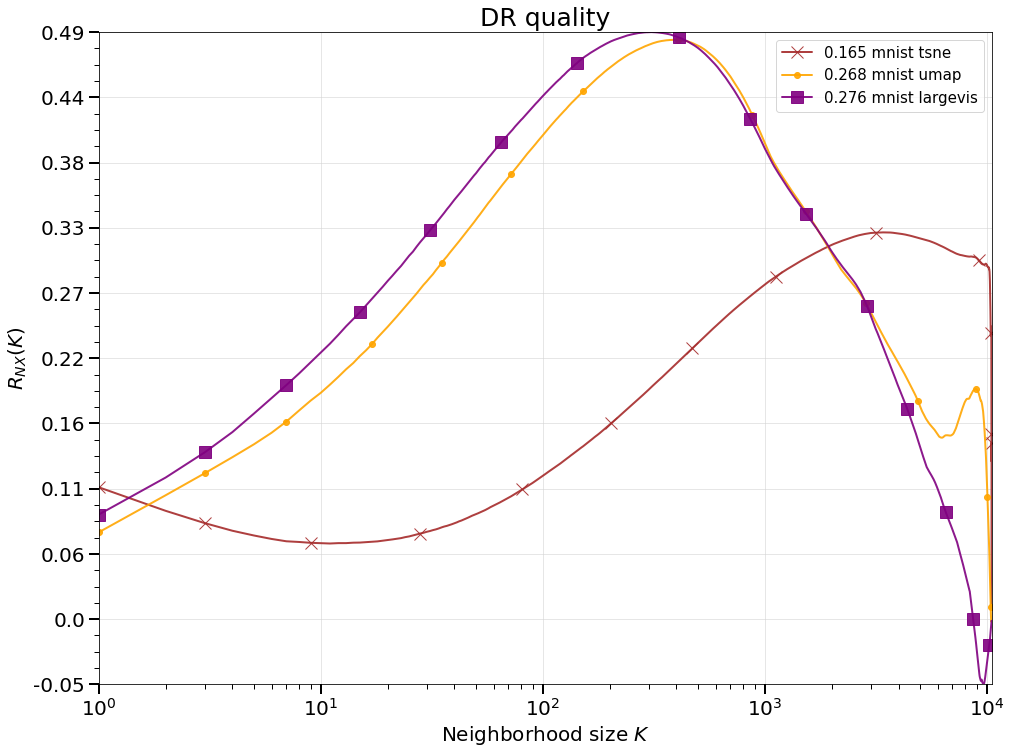

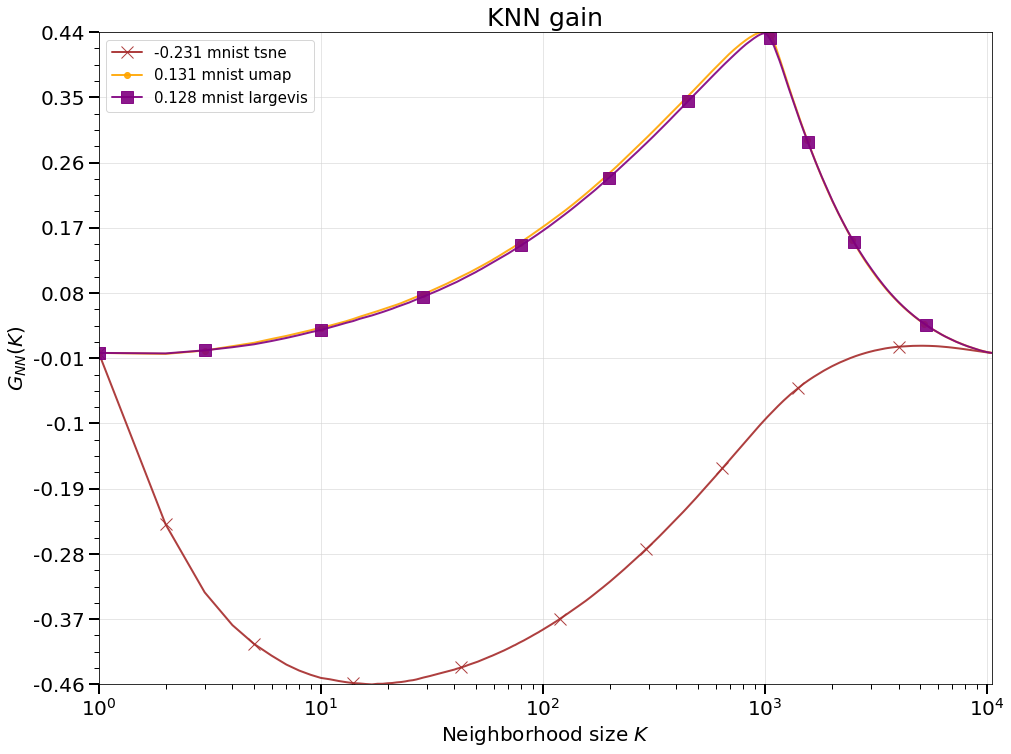

In [35]:
mnist_local_metrics.visualize()
# there's also a second metric which wasn't calculated, refresh this module.

In [36]:
X = fmnist.data
labels = fmnist.target

fmnist_local_metrics = LocalMetric()
fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_tsne_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "tsne"),
)

fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_umap_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "umap"),
)

fmnist_local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_largevis_X,
    X_hds=X.values,
    labels=labels.values.to_numpy(dtype=np.int8),
    method_name="{} {}".format("fmnist", "largevis"),
)

Calculating d_hd
fmnist tsne
Calculating d_hd
fmnist umap
Calculating d_hd
fmnist largevis


Finished.


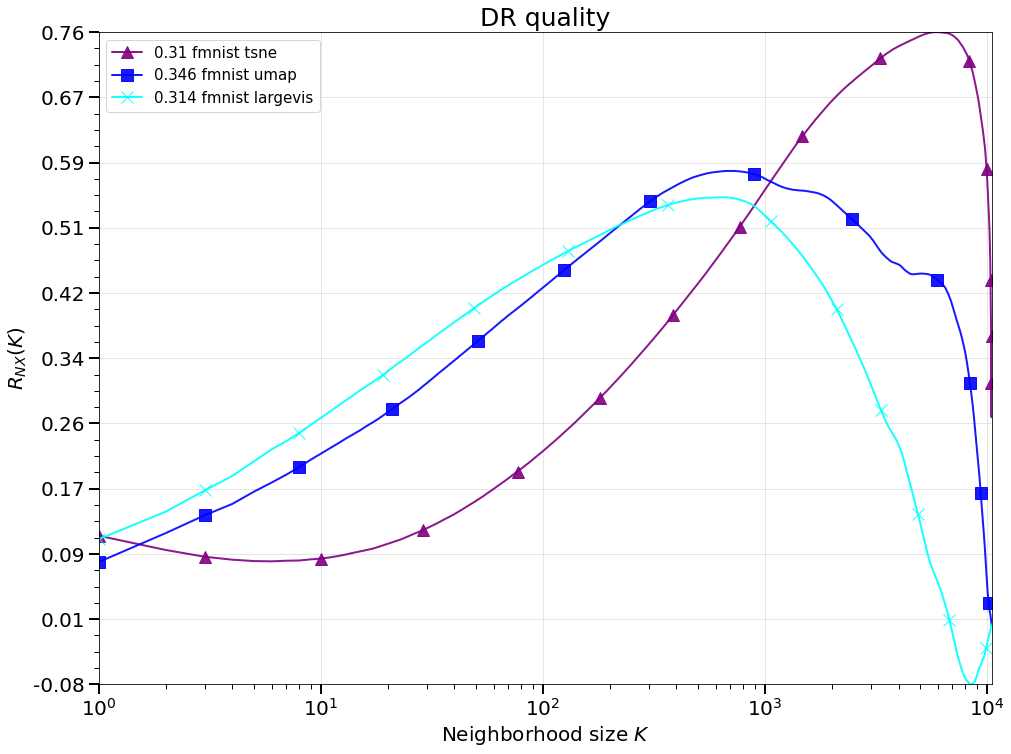

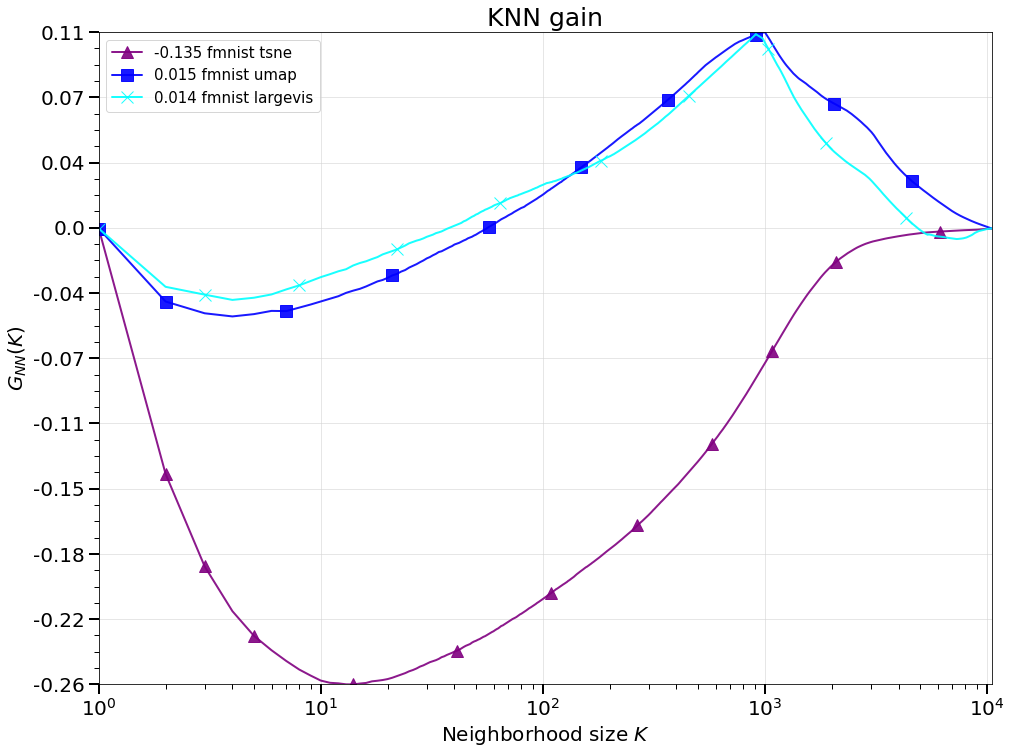

In [37]:
# largevis_mnist_data
fmnist_local_metrics.visualize()